# Projection on vertical modes

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import crocosi.postp as pp
from crocosi.gridop import get_z

# Read netcdf file

In [2]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp9_4km_nodecay_2000a2300j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=[], grid_params=gparams)

<xarray.Dataset>
Dimensions:              (axis_nbounds: 2, s_rho: 50, time: 12, x_rho: 258, x_u: 257, x_v: 258, x_w: 258, y_rho: 722, y_u: 722, y_v: 721, y_w: 722)
Coordinates:
    xi_w                 (y_w, x_w) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_u                (y_u, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    xi_u                 (y_u, x_u) float32 dask.array<chunksize=(722, 257), meta=np.ndarray>
    eta_v                (y_v, x_v) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    eta_w                (y_w, x_w) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    eta_rho              (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
    xi_v                 (y_v, x_v) float32 dask.array<chunksize=(721, 258), meta=np.ndarray>
    xi_rho               (y_rho, x_rho) float32 dask.array<chunksize=(722, 258), meta=np.ndarray>
  * s_rho                (s_rho) float32 -0.99 -0.97 -0.95 ...

# Compute vertical modes
ssh temporal mean

In [3]:
sshmean = r.ds['his'].ssh_a.mean(dim='time')

Compute z mean from ssh mean

/home1/dunree/slgentil/models/croco/croco/crocosi/gridop.py:109: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(sc.dims[0], _zeta.dims[0], _zeta.dims[1])


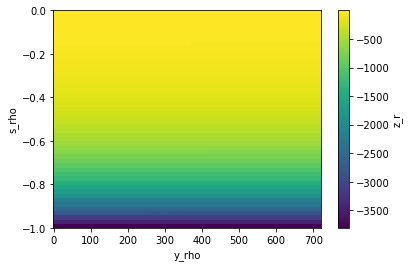

In [4]:
zmean = get_z(r, zeta=sshmean, h=r.ds['his'].h, vgrid='r', hgrid='r')
zmean.isel(x_rho=125).plot(x='y_rho', y='s_rho')

Interpolate vertically stratification T(x,y,z,t)  on zmean -> T(x,y,$\bar{z}$,t)

Temporal mean of stratification T(x,y,$\bar{z}$,t) -> T(x,y,$\bar{z}$)

Compute N2 profile from stratification on mean z  T(x,y,$\bar{z}$) -> N2(x,y,$\bar{z}$)

Compute vertical modes N2(x,y,$\bar{z}$) -> $phi_{n}$(x,y,$\bar{z}$)

# Projection of a variable on vertical modes

Interpolation of the variable on zmean -> var(x,y,$\bar{z}$,t)

Projection on vertical modes -> $var_{n}$(x,y,t)